--------------------------------------------------
Text of the caption:
its their character not their color that matters
--------------------------------------------------


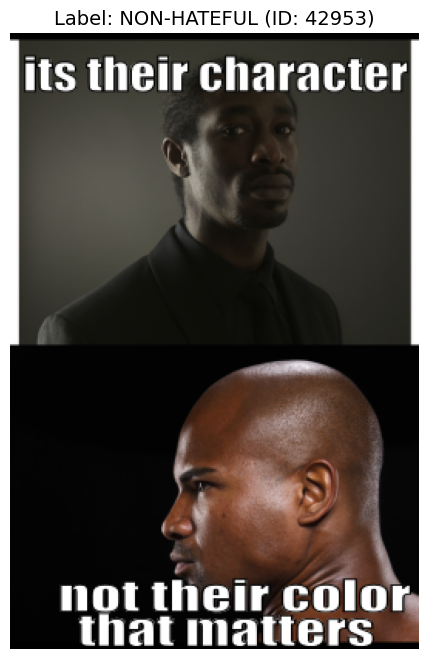

In [1]:
import pandas as pd
import os
from PIL import Image
import matplotlib.pyplot as plt

# Path to the dataset
BASE_PATH = "/home/gusdebanb@GU.GU.SE/.cache/kagglehub/datasets/parthplc/facebook-hateful-meme-dataset/versions/1/data" 
TRAIN_FILE = os.path.join(BASE_PATH, "train.jsonl")

# Load of the training dataset
df_train = pd.read_json(TRAIN_FILE, lines=True)

# Aggiunta del percorso assoluto
def create_full_path(relative_path):
    return os.path.join(BASE_PATH, relative_path)

df_train['full_path'] = df_train['img'].apply(create_full_path)

def display_meme_sample(df, index):
    """Visualize memes wit textual informations"""
    
    # 1. Extraction of data
    sample = df.iloc[index]
    image_path = sample['full_path']
    meme_text = sample['text']
    label = "HATEFUL" if sample['label'] == 1 else "NON-HATEFUL"
    
    # 2. Data loading
    try:
        img = Image.open(image_path)
    except FileNotFoundError:
        print(f"Error: Image not found at path {image_path}")
        return

    # 3. Image visualization
    plt.figure(figsize=(8, 8))
    plt.imshow(img)
    plt.title(f"Label: {label} (ID: {sample['id']})", fontsize=14)
    plt.axis('off')
    
    # Text
    print("-" * 50)
    print(f"Text of the caption:\n{meme_text}")
    print("-" * 50)
    plt.show()

# First indexed meme of the dataset
display_meme_sample(df_train, 0) 

# Find the first meme labeled as HATEFUL
#hateful_index = df_train[df_train['label'] == 1].index[0]
#display_meme_sample(df_train, hateful_index)

In [2]:
import torch
from torch.utils.data import Dataset, DataLoader
import json
import os
from PIL import Image
import clip

class HatefulMemesDataset(Dataset):
    """
    Custom dataset to load Hateful Memes Challenge data.
    Expects the jsonl files and img/ folder to be in the same base directory.
    """
    def __init__(self, data_path, img_dir, preprocess):
        self.img_dir = img_dir
        self.preprocess = preprocess
        
        # Loading of json file's line
        with open(data_path, 'r', encoding='utf-8') as f:
            self.data = [json.loads(line) for line in f]
            
        # Classes for tokenization
        self.class_names = ["non-hateful meme", "hateful meme"]

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        entry = self.data[idx]
        
        # Meme datas
        text = entry['text']
        img_filename = entry['img']

         # If label is not present use "-1" as a placeholder
        if 'label' in entry:
            label = torch.tensor(entry['label'], dtype=torch.long)
            has_label = True
        else:
            label = torch.tensor(-1, dtype=torch.long) 
            has_label = False
            
        # Image loading and pre-processing
        img_path = os.path.join(self.img_dir, os.path.basename(img_filename))
        image = Image.open(img_path).convert("RGB")
        image = self.preprocess(image)

        # Text tokenization using CLIP's tokenizer
        text_tokens = clip.tokenize(text, truncate=True)

        #return image, text_tokens.squeeze(0), torch.tensor(label, dtype=torch.long)
        return image, text_tokens.squeeze(0), label, has_label 


NUM_CLASSES = 2
CLIP_MODEL = "ViT-B/32" # Light and balanced model to use

IMAGE_DIR = "/home/gusdebanb@GU.GU.SE/.cache/kagglehub/datasets/parthplc/facebook-hateful-meme-dataset/versions/1/data/img"
TRAIN_JSONL = "/home/gusdebanb@GU.GU.SE/.cache/kagglehub/datasets/parthplc/facebook-hateful-meme-dataset/versions/1/data/train.jsonl"
DEV_JSONL = "/home/gusdebanb@GU.GU.SE/.cache/kagglehub/datasets/parthplc/facebook-hateful-meme-dataset/versions/1/data/dev.jsonl" 
MODEL_SAVE_PATH = "best_clip_classifier.pth" 
device = "cuda" if torch.cuda.is_available() else "cpu"

In [3]:
import torch.nn as nn
import torch.optim as optim

class CLIPClassifier(nn.Module):
    """
    Model that uses CLIP feature extractors and adds a classification head.
    Implements a late fusion strategy (concatenation of embeddings).
    """
    def __init__(self, clip_model, num_classes):
        super().__init__()
        self.clip = clip_model
        
        # Embedding dimension of CLIP
        embedding_dim = self.clip.token_embedding.weight.shape[-1]
        
        # Freeze of the parameters
        for param in self.clip.parameters():
            param.requires_grad = False
            
        # The classification head will work on the concatenation of image and text embeddings.
        # Total size: 512 (image) + 512 (text) = 1024
        fusion_dim = embedding_dim * 2 
        
        self.classifier = nn.Sequential(
            nn.Linear(fusion_dim, fusion_dim // 2),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(fusion_dim // 2, num_classes) # Output: 2 classes (0 or 1)
        )

    def forward(self, images, text_tokens, ablation_mode='multimodal'):
        """
        Forward pass with ablation support
        ablation_mode: 'multimodal' (default), 'image_only', 'text_only'.
        """

        batch_size = images.shape[0]
        embedding_dim = self.embedding_dim
        
        # Initialize feature vectors
        image_features = None
        text_features = None

        zero_vector = torch.zeros(batch_size, embedding_dim, 
                                  device=images.device, dtype=torch.float)
        
        # 1. Get image and text embeddings from CLIP
        # We use torch.no_grad() if we decide to freeze CLIP completely
        with torch.no_grad():
            
            # --- Image mode ---
            if ablation_mode == 'image_only' or ablation_mode == 'multimodal':
                image_features = self.clip.encode_image(images)
                # 2. Normalize
                image_features = image_features / image_features.norm(dim=-1, keepdim=True)
            else: # Mode Text-Only: image ablation
                image_features = zero_vector
            
            # --- Text mode ---
            if ablation_mode == 'text_only' or ablation_mode == 'multimodal':
                text_features = self.clip.encode_text(text_tokens)
                # 2. Normalize
                text_features = text_features / text_features.norm(dim=-1, keepdim=True)
            else: # Mode Image-Only: text ablation
                text_features = zero_vector
        
        
        # 3. Concatenation (Late Fusion)
        fused_features = torch.cat((image_features, text_features), dim=1)
        
        # 4. Classification
        logits = self.classifier(fused_features.float())
        
        return logits

# Load the pre-trained model and pre-processing function
clip_base_model, preprocess = clip.load(CLIP_MODEL, device=device)

# Creation of the classification model
model = CLIPClassifier(clip_base_model, NUM_CLASSES).to(device)

# To unlock the top layer of clip for fine-tuning
for param in model.clip.visual.transformer.resblocks[-1].parameters():
    param.requires_grad = True

In [4]:
from sklearn.metrics import roc_auc_score
def evaluate_model(model, loader, criterion, device, ablation_mode='multimodal'):
    """Calculate the loss, accuracy, and AUROC on the given dataset."""
    model.eval()
    
    running_loss = 0.0
    correct_predictions = 0
    total_samples = 0
    
    # List to collect the results needed for the AUROC
    all_labels = []
    all_probabilities = []
    
    with torch.no_grad():
        for images, text_tokens, labels, has_label in loader:
            # Filter only samples that have the label
            valid_indices = (labels != -1)
            if valid_indices.sum() == 0:
                continue
                
            images = images[valid_indices].to(device)
            text_tokens = text_tokens[valid_indices].to(device)
            labels_valid = labels[valid_indices].to(device)
            
            outputs = model(images, text_tokens, ablation_mode=ablation_mode)
            loss = criterion(outputs, labels_valid)
            
            # 1. Calculate Accuracy and Loss
            running_loss += loss.item() * labels_valid.size(0)
            _, predicted = torch.max(outputs.data, 1)
            total_samples += labels_valid.size(0)
            correct_predictions += (predicted == labels_valid).sum().item()
            
            # 2. Transformation of logits into probabilities
            probabilities = torch.softmax(outputs, dim=1)
            
            # Probability of te class
            all_probabilities.extend(probabilities[:, 1].cpu().numpy())
            all_labels.extend(labels_valid.cpu().numpy())

    avg_loss = running_loss / total_samples
    accuracy = correct_predictions / total_samples
    
    # 3. AUROC calculation
    if total_samples > 0 and len(set(all_labels)) > 1:
        auroc = roc_auc_score(all_labels, all_probabilities)
    else:
        auroc = 0.0 # Fallback value
    
    model.train()
    
    return avg_loss, accuracy, auroc 

In [5]:
# 1. DataLoaders
train_dataset = HatefulMemesDataset(TRAIN_JSONL, IMAGE_DIR, preprocess)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
dev_dataset = HatefulMemesDataset(DEV_JSONL, IMAGE_DIR, preprocess)
dev_loader = DataLoader(dev_dataset, batch_size=32, shuffle=False) # Shuffle False for coherence

# 2. Optimizatior and Loss function
# Optimize only the unfrozen layers
optimizer = optim.AdamW(model.classifier.parameters(), lr=1e-3) 
criterion = nn.CrossEntropyLoss()

def train_model(model, train_loader, dev_loader, criterion, optimizer, device, epochs, save_path):
    
    best_dev_auroc = -1.0
    
    for epoch in range(epochs):
        # ------------------------------------------------------
        # TRAINING PHASE
        # ------------------------------------------------------
        model.train()
        train_loss = 0.0
        
        for i, (images, text_tokens, labels, has_label) in enumerate(train_loader):
            images = images.to(device)
            text_tokens = text_tokens.to(device)
            labels = labels.to(device)
            
            optimizer.zero_grad()
            outputs = model(images, text_tokens)
            loss = criterion(outputs, labels)
            
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item()
            
            if (i + 1) % 100 == 0:
                print(f"Epoch [{epoch+1}/{epochs}], Step [{i+1}/{len(train_loader)}], Train Loss: {loss.item():.4f}")
                
        avg_train_loss = train_loss / len(train_loader)
        
        # ------------------------------------------------------
        # VALIDATION PHASE
        # ------------------------------------------------------
        dev_loss, dev_accuracy, dev_auroc = evaluate_model(model, dev_loader, criterion, device) 

        print(f"\n--- Epoch {epoch+1} Results ---")
        print(f"Avg Train Loss: {avg_train_loss:.4f}")
        print(f"Dev Loss: {dev_loss:.4f}, Dev Accuracy: {dev_accuracy:.4f}, Dev AUROC: {dev_auroc:.4f}")
        
        # ------------------------------------------------------
        # BEST MODEL SAVING
        # ------------------------------------------------------
        if dev_auroc > best_dev_auroc:
            print(f"⭐ Dev AUROC improved from {best_dev_auroc:.4f} to {dev_auroc:.4f}. Model saved to path: {save_path}")
            best_dev_auroc = dev_auroc
            
            torch.save(model.classifier.state_dict(), save_path)
            
        else:
            print(f"Dev AUROC ({dev_auroc:.4f}) has not improved the best score: ({best_dev_auroc:.4f}).")

# Start of the training
print(f"Training started on device {device}.")
train_model(
    model=model, 
    train_loader=train_loader, 
    dev_loader=dev_loader, 
    criterion=criterion, 
    optimizer=optimizer, 
    device=device, 
    epochs=15,
    save_path=MODEL_SAVE_PATH
)

Training started on device cuda.
Epoch [1/15], Step [100/266], Train Loss: 0.5363
Epoch [1/15], Step [200/266], Train Loss: 0.5651

--- Epoch 1 Results ---
Avg Train Loss: 0.5694
Dev Loss: 0.6975, Dev Accuracy: 0.5920, Dev AUROC: 0.6652
⭐ Dev AUROC improved from -1.0000 to 0.6652. Model saved to path: best_clip_classifier.pth
Epoch [2/15], Step [100/266], Train Loss: 0.4906
Epoch [2/15], Step [200/266], Train Loss: 0.4849

--- Epoch 2 Results ---
Avg Train Loss: 0.5106
Dev Loss: 0.7120, Dev Accuracy: 0.5880, Dev AUROC: 0.6805
⭐ Dev AUROC improved from 0.6652 to 0.6805. Model saved to path: best_clip_classifier.pth
Epoch [3/15], Step [100/266], Train Loss: 0.5206
Epoch [3/15], Step [200/266], Train Loss: 0.4498

--- Epoch 3 Results ---
Avg Train Loss: 0.4780
Dev Loss: 0.7590, Dev Accuracy: 0.5980, Dev AUROC: 0.6862
⭐ Dev AUROC improved from 0.6805 to 0.6862. Model saved to path: best_clip_classifier.pth
Epoch [4/15], Step [100/266], Train Loss: 0.4440
Epoch [4/15], Step [200/266], Train

# Test of the ablation on the validation dataset

In [6]:
import numpy as np
from scipy.special import softmax

def predict_model(model, loader, device):
    """Generate predictions (logits) for the loader of the test set"""
    model.eval() 
    all_logits = []
    all_ids = []
    
    with torch.no_grad():
        for i, (images, text_tokens, _, _) in enumerate(loader):
            images = images.to(device)
            text_tokens = text_tokens.to(device)
            
            outputs = model(images, text_tokens)
            all_logits.append(outputs.cpu().numpy())

    all_logits = np.concatenate(all_logits, axis=0)
    
    # To get the label
    predictions = np.argmax(all_logits, axis=1)
    
    # Probability of the Positive class
    probabilities = softmax(all_logits, axis=1)
    
    return predictions, probabilities # Return the binary prediction and probability

In [7]:
def display_predicted_meme(df, index):
    """Visualization of a meme with his predicted label."""
    
    # 1. Extract datas
    sample = df.iloc[index]
    image_path = sample['full_path']
    meme_text = sample['text']
    
    # Predicted label
    predicted_label = "HATE" if sample['predicted_label'] == 1 else "NON-HATE"
    probability = sample['hateful_probability']
    
    # 2. Image loading
    try:
        img = Image.open(image_path)
    except FileNotFoundError:
        print(f"Error: Image not found at path {image_path}")
        return

    # 3. Visualization
    plt.figure(figsize=(8, 8))
    plt.imshow(img)
    
    title_text = (
        f"Predicted: {predicted_label} (ID: {sample['id']})\n"
        f"Probability HATE: {probability:.4f}"
    )
    plt.title(title_text, fontsize=14)
    plt.axis('off')
    
    # Print of the caption text
    print("-" * 50)
    print(f"Text of the caption:\n{meme_text}")
    print("-" * 50)
    plt.show()

In [12]:
TEST_JSONL = "/home/gusdebanb@GU.GU.SE/.cache/kagglehub/datasets/parthplc/facebook-hateful-meme-dataset/versions/1/data/test.jsonl"
test_dataset = HatefulMemesDataset(TEST_JSONL, IMAGE_DIR, preprocess)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Generate predictions on the test dataset
test_predictions, test_probabilities = predict_model(model, test_loader, device)

# Load the Dataframe
df_test = pd.read_json(TEST_JSONL, lines=True)

# Add absolute path for every image
def create_full_path(relative_path):
    return os.path.join(BASE_PATH, relative_path)

df_test['full_path'] = df_test['img'].apply(create_full_path)

# Add model predictions to the Test DataFrame
df_test['predicted_label'] = test_predictions

# Add the probabilities of the 'HATE' class
df_test['hateful_probability'] = test_probabilities[:, 1]

Visualization of a meme predicted as NON-HATEFUL:
--------------------------------------------------
Text of the caption:
rare picture of a dishwasher at birth
--------------------------------------------------


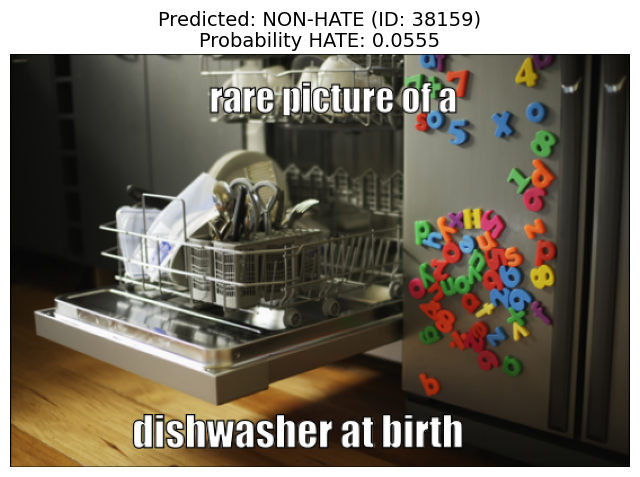


Visualization of a meme predicted as HATEFUL:
--------------------------------------------------
Text of the caption:
mommy, why am i getting christmas presents in august? because it's cheaper than chemotherapy
--------------------------------------------------


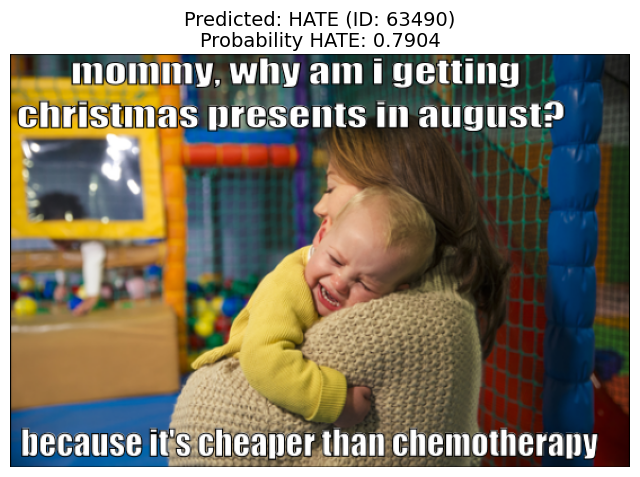


isualization of the meme predicted as  HATEFUL with the highest probability
--------------------------------------------------
Text of the caption:
went down on a muslim bitch her pussy was the bomb!
--------------------------------------------------


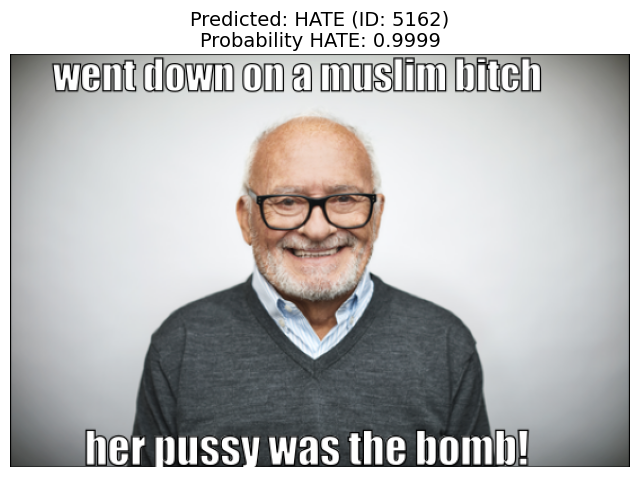

In [13]:
import random
non_hateful_index = df_test[df_test['predicted_label'] == 0].index[random.randint(0, len(df_test) - 1)]
print("Visualization of a meme predicted as NON-HATEFUL:")
display_predicted_meme(df_test, non_hateful_index)

# -----------------------------------------------------------------

hateful_index = df_test[df_test['predicted_label'] == 1].index[random.randint(0, len(df_test[df_test['predicted_label'] == 1]) - 1)]
print("\nVisualization of a meme predicted as HATEFUL:")
display_predicted_meme(df_test, hateful_index)

# -----------------------------------------------------------------

most_confident_hateful_index = df_test['hateful_probability'].idxmax()
print("\nisualization of the meme predicted as  HATEFUL with the highest probability")
display_predicted_meme(df_test, most_confident_hateful_index)